# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import resample

import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, MaxPool1D, Convolution1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical

import random

# importing data

In [ ]:
train_data = pd.read_csv('/content/mitbih_test.csv')
test_data = pd.read_csv('/content/mitbih_train.csv')

# Classes of data

Count in each label: 
0    72470
4     6431
2     5788
1     2223
3      641
Name: 0.000000000000000000e+00.88, dtype: int64


<BarContainer object of 5 artists>

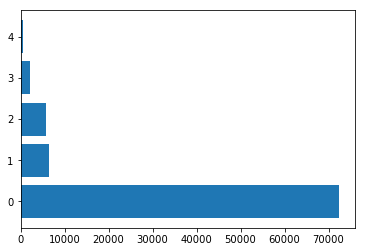

In [ ]:
label_names = ['Non-ecotic beats (normal beat)', 'Supraventricular ectopic beats', 'Ventricular ectopic beats', 'Fusion beats', 'Unknown beats']

labels = train_data.iloc[:,187].astype('int64')   # last column has the labels

print("Count in each label: ")
print(labels.value_counts())

plt.barh(list(set(labels)), list(labels.value_counts()))

In [ ]:
print(label_names[0])

Non-ecotic beats (normal beat)


#### Since the data is very non-uniformly devided, we are resampling it for uniformity

In [ ]:
# Separating the train dataframe into 5 individual ones based on class labels, and sampling 50000 from each.

train_lbl0 = resample(train_data[train_data.iloc[:,187]==0], replace=True, n_samples=50000, random_state=113)
train_lbl1 = resample(train_data[train_data.iloc[:,187]==1], replace=True, n_samples=50000, random_state=113)
train_lbl2 = resample(train_data[train_data.iloc[:,187]==2], replace=True, n_samples=50000, random_state=113)
train_lbl3 = resample(train_data[train_data.iloc[:,187]==3], replace=True, n_samples=50000, random_state=113)
train_lbl4 = resample(train_data[train_data.iloc[:,187]==4], replace=True, n_samples=50000, random_state=113)



In [ ]:
#Merging all the data in one
train = pd.concat([train_lbl0, train_lbl1, train_lbl2, train_lbl3, train_lbl4])

labels = train.iloc[:,187].astype('int64')   # last column has the labels

print("Count in each label: ")
print(labels.value_counts())

Count in each label: 
0    50000
1    50000
2    50000
3    50000
4    50000
Name: 0.000000000000000000e+00.88, dtype: int64


# Visualising the beats

Text(0.5, 1.0, 'Non-ecotic beats (normal beat)')

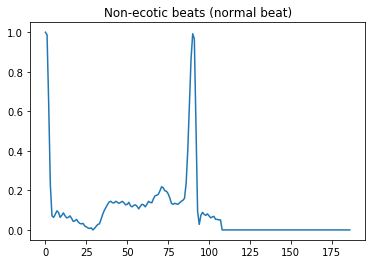

In [ ]:
plt.plot(np.array(train_lbl0.sample(1))[0, :187])
plt.title(label_names[0])

Text(0.5, 1.0, 'Supraventricular ectopic beats')

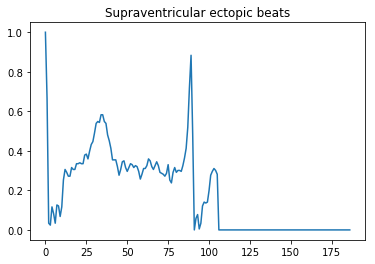

In [ ]:
plt.plot(np.array(train_lbl1.sample(1))[0, :187])
plt.title(label_names[1])


Text(0.5, 1.0, 'Ventricular ectopic beats')

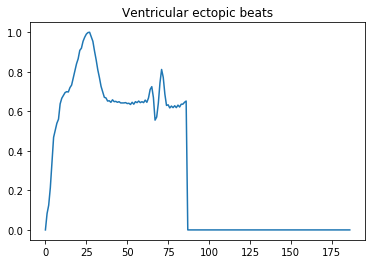

In [ ]:
plt.plot(np.array(train_lbl2.sample(1))[0, :187])
plt.title(label_names[2])


Text(0.5, 1.0, 'Fusion beats')

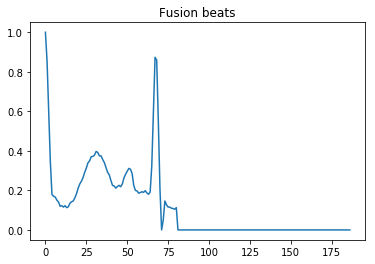

In [ ]:
plt.plot(np.array(train_lbl3.sample(1))[0, :187])
plt.title(label_names[3])


Text(0.5, 1.0, 'Unknown beats')

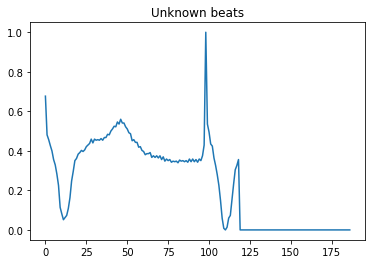

In [ ]:
plt.plot(np.array(train_lbl4.sample(1))[0, :187])
plt.title(label_names[4])

# Preprocessing

In [ ]:
# Adding some noise to increase efficiency of the trained model

def gaussian_noise(signal):
    noise = np.random.normal(0,0.05,187)
    return signal + noise

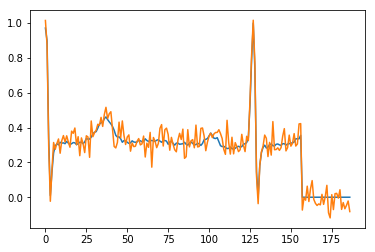

In [ ]:
# Visualization with added noise

sample = train_lbl0.sample(1).values[0]

sample_with_noise = gaussian_noise(sample[:187])

plt.subplot(1, 1, 1)

plt.plot(sample[:187])
plt.plot(sample_with_noise)

In [ ]:
# One hot encoding the output of the model

ytrain = to_categorical(train.iloc[:,187])
ytest = to_categorical(test_data.iloc[:,187])

# Input data to the model
xtrain = train.values[:, :187]
xtest = test_data.values[:, :187]

# Adding noise to all rows
for i in range(xtrain.shape[0]):
    xtrain[i, :187] = gaussian_noise(xtrain[i, :187])

In [ ]:
# Viewing the shapes

xtrain = np.expand_dims(xtrain, 2)
xtest = np.expand_dims(xtest, 2)

print("Shape of training data: ")
print("Input: ", xtrain.shape)
print("Output: ", ytrain.shape)

print("\nShape of test data: ")
print("Input: ", xtest.shape)
print("Output: ", ytest.shape)

Shape of training data: 
Input:  (250000, 187, 1)
Output:  (250000, 5)

Shape of test data: 
Input:  (21891, 187, 1)
Output:  (21891, 5)


# Building & Compiling the model

In [ ]:
model = Sequential()
model.add(Conv1D(64, 6, activation = 'relu', input_shape = xtrain[0].shape))
model.add(MaxPool1D(3, 2))

model.add(Conv1D(64, 6, activation = 'relu'))
model.add(MaxPool1D(3, 2))

model.add(Conv1D(64, 6, activation = 'relu'))
model.add(MaxPool1D(3, 2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))

model.compile(optimizer = keras.optimizers.Adam(0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 182, 64)           448       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 90, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 85, 64)            24640     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 42, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 37, 64)            24640     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 18, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

# Training the model

In [ ]:
history = model.fit(xtrain, ytrain, epochs = 20, batch_size = 32, validation_data = (xtest, ytest))

Epoch 1/20
7813/7813 [==============================] - 162s 19ms/step - loss: 0.3608 - accuracy: 0.8672 - val_loss: 0.2098 - val_accuracy: 0.9281
Epoch 2/20
7813/7813 [==============================] - 151s 19ms/step - loss: 0.1010 - accuracy: 0.9635 - val_loss: 0.1745 - val_accuracy: 0.9431
Epoch 3/20
7813/7813 [==============================] - 144s 18ms/step - loss: 0.0687 - accuracy: 0.9758 - val_loss: 0.1288 - val_accuracy: 0.9620
Epoch 4/20
7813/7813 [==============================] - 143s 18ms/step - loss: 0.0534 - accuracy: 0.9815 - val_loss: 0.1326 - val_accuracy: 0.9634
Epoch 5/20
7813/7813 [==============================] - 143s 18ms/step - loss: 0.0447 - accuracy: 0.9842 - val_loss: 0.1272 - val_accuracy: 0.9686
Epoch 6/20
7813/7813 [==============================] - 142s 18ms/step - loss: 0.0386 - accuracy: 0.9867 - val_loss: 0.1461 - val_accuracy: 0.9612
Epoch 7/20
7813/7813 [==============================] - 139s 18ms/step - loss: 0.0357 - accuracy: 0.9875 - val_loss: 0

# Plotting the accuracy, validation accuracy, loss, val_loss of model

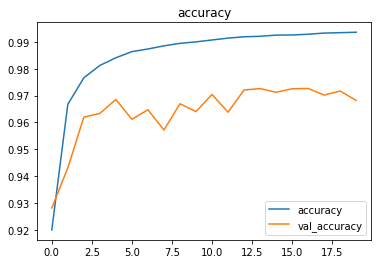

In [ ]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.legend([variable, variable2])
    plt.title(variable)
    
plot(history.history, "accuracy","val_accuracy")

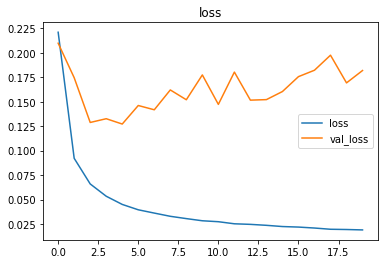

In [ ]:
plot(history.history, "loss", "val_loss")

# Predicting and plotting confusion matrix for test data

In [ ]:
ypred = model.predict(xtest)

In [ ]:
cm = confusion_matrix(ytest.argmax(axis=1), ypred.argmax(axis=1))
print(cm)

[[17633   221    84   163    16]
 [   75   464    11     4     2]
 [   36     8  1369    31     4]
 [    8     0    13   141     0]
 [   17     1     2     0  1588]]


In [ ]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

[[9.73284760e-01 1.21984876e-02 4.63652923e-03 8.99707457e-03
  8.83148424e-04]
 [1.34892086e-01 8.34532374e-01 1.97841727e-02 7.19424460e-03
  3.59712230e-03]
 [2.48618785e-02 5.52486188e-03 9.45441989e-01 2.14088398e-02
  2.76243094e-03]
 [4.93827160e-02 0.00000000e+00 8.02469136e-02 8.70370370e-01
  0.00000000e+00]
 [1.05721393e-02 6.21890547e-04 1.24378109e-03 0.00000000e+00
  9.87562189e-01]]


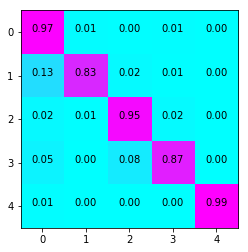

In [ ]:
for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="black")

plt.imshow(cm, cmap=plt.cm.cool)

In [ ]:
model.save('ECG_Classification.model')

INFO:tensorflow:Assets written to: ECG_Classification.model/assets


In [ ]:
ytest.argmax(axis=1)

array([0, 0, 0, ..., 4, 4, 4])